In [1]:
import tensorflow as tf
import os
import numpy as np
import matplotlib.pyplot as plt
import pathlib

In [3]:
def augment_data(image):
    image = tf.image.resize_with_crop_or_pad(image, 180, 180) # Add 6 pixels of padding
    image = tf.image.random_crop(image, size=[150, 150, 3]) # Random crop back to 28x28
    image = tf.image.random_brightness(image, max_delta=0.5) # Random brightness

    return image

In [4]:
dataset = "F:\python_projects\Diabetic_Retinopathy\dataset"

In [5]:
train_dir = pathlib.Path(dataset)
print(train_dir)

F:\python_projects\Diabetic_Retinopathy\dataset


In [6]:
CLASS_NAMES = np.array([item.name for item in train_dir.glob('*') if item.name != "LICENSE.txt"])
print(CLASS_NAMES)

['0' '1' '2' '3' '4']


In [7]:
full_dataset = tf.data.Dataset.list_files(str(train_dir/'*/*'))
validation_split = 0.2


In [8]:
DATASET_SIZE = len(list(full_dataset))
print("Dataset size: ", DATASET_SIZE)
train_size = int((1-validation_split) * DATASET_SIZE)
print("train size: ", train_size)
train_dataset = full_dataset.take(train_size)
validation_dataset = full_dataset.skip(train_size)

Dataset size:  35126
train size:  28100


In [9]:
def get_label(file_path):
  # convert the path to a list of path components
  parts = tf.strings.split(file_path, os.path.sep)
  # The second to last is the class-directory
  return parts[-2] == CLASS_NAMES

In [10]:
def load_img(image_path):
    img = tf.io.read_file(image_path)
    
    # https://stackoverflow.com/questions/44942729/tensorflowvalueerror-images-contains-no-shape
    img = tf.image.decode_image(img, 3, expand_animations=False)
    
    img = tf.cast(img, tf.float32)
    return img

In [11]:
def resize(image,height, width):
    image = tf.image.resize(image, (height, width),
                                 method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    #image = tf.image.resize_with_crop_or_pad(image, height, width)
    return image

In [12]:
# normalizing the images to [-1, 1]
def normalize(image):
    image = (image / 127.5) - 1
    return image

In [13]:
def load_image_with_label(image_path):
    label = get_label(image_path)
    img = load_img(image_path)
    return img, label

In [15]:
def load_image_train(image_file):
    image, label = load_image_with_label(image_file)
    image = augment_data(image)
    image = normalize(image)
    
    return image, label

In [16]:
def load_image_test(image_file):
    image, label = load_image_with_label(image_file)
    image = resize(image, 150, 150)
    image = normalize(image)

    return image, label

In [17]:
BATCH_SIZE = 32
SHUFFLE_BUFFER_SIZE = 1000

In [18]:
train_dataset = train_dataset.map(load_image_train)
train_dataset = train_dataset.shuffle(SHUFFLE_BUFFER_SIZE)
train_dataset = train_dataset.batch(BATCH_SIZE)

In [19]:
validation_dataset = validation_dataset.map(load_image_test)
validation_dataset = validation_dataset.batch(BATCH_SIZE)

In [20]:
base_model = tf.keras.applications.InceptionV3(weights='imagenet',
                  include_top=False,
                  input_shape=(150, 150, 3))

In [21]:
base_model.trainable = False

In [22]:
n_class =len(CLASS_NAMES)

In [23]:
flatten_layer = tf.keras.layers.GlobalAveragePooling2D()
dense_layer = tf.keras.layers.Dense(100, activation='relu')
dropout_layer = tf.keras.layers.Dropout(0.5)
prediction_layer = tf.keras.layers.Dense(n_class, activation='softmax')

In [24]:
model = tf.keras.Sequential([
  base_model,
  flatten_layer,
  dense_layer,
  dropout_layer,
  prediction_layer
])

In [25]:
model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.01),
              loss=tf.keras.losses.categorical_crossentropy,
              metrics=['accuracy'])

In [27]:
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=validation_dataset)

Epoch 1/10
879/879 [==============================] - 497s 551ms/step - loss: 0.9123 - accuracy: 0.7337 - val_loss: 6.8858 - val_accuracy: 0.7347
Epoch 2/10
879/879 [==============================] - 519s 573ms/step - loss: 0.9002 - accuracy: 0.7358 - val_loss: 3.6052 - val_accuracy: 0.7340
Epoch 3/10
879/879 [==============================] - 435s 479ms/step - loss: 0.9121 - accuracy: 0.7358 - val_loss: 3.1999 - val_accuracy: 0.7323
Epoch 4/10
879/879 [==============================] - 439s 485ms/step - loss: 0.9098 - accuracy: 0.7327 - val_loss: 4.5807 - val_accuracy: 0.7336
Epoch 5/10
879/879 [==============================] - 480s 530ms/step - loss: 0.8914 - accuracy: 0.7362 - val_loss: 6.1753 - val_accuracy: 0.7272
Epoch 6/10
879/879 [==============================] - 409s 449ms/step - loss: 0.9132 - accuracy: 0.7350 - val_loss: 13.0009 - val_accuracy: 0.7337
Epoch 7/10
879/879 [==============================] - 455s 503ms/step - loss: 0.9138 - accuracy: 0.7347 - val_loss: 11.9878

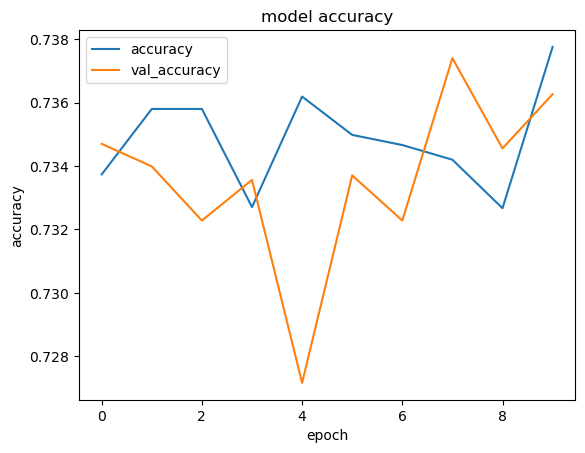

In [31]:
def display_accuracy() -> None:
    # Summarize history for accuracy
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['accuracy', 'val_accuracy'], loc='upper left')
    plt.show()
display_accuracy()

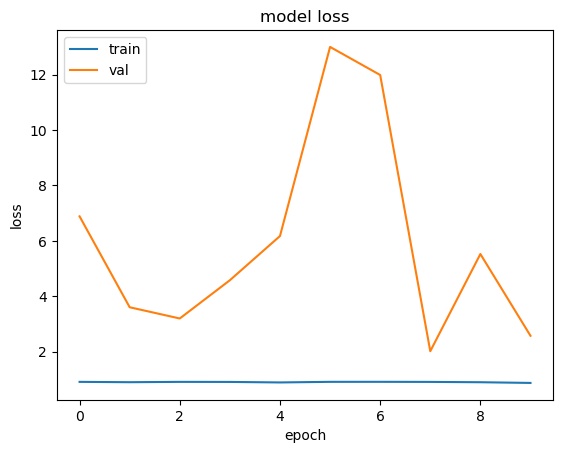

In [32]:
def display_loss() -> None:
    # Summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()
display_loss()